# Autograd (4)：PyTorch 高阶自动导数

PyTorch 的 Autograd 不仅可以作为一阶导数的计算工具，还可以对任意阶的高阶导数作计算。这篇文档我们简单地讨论这个问题。

这篇文档若没有 [Stackoverflow 回答](https://stackoverflow.com/questions/50322833/higher-order-gradients-in-pytorch)，恐怕是不会写出来了。

In [1]:
%matplotlib notebook

import torch
from torch.autograd import grad
import numpy as np
import scipy
import scipy.linalg
from matplotlib import pyplot as plt

torch.set_printoptions(precision=5, sci_mode=False, linewidth=120)

## 一元函数的高阶导数

我们仍然拿以下的函数

$$
y (b) = x^3 + 10 \exp \left( - \frac{x^2}{10} \right)
$$

其中，当 $x = 3$ 时，$y \simeq 31.07$。

In [2]:
x = torch.tensor(3., requires_grad=True)
y = x**3 + 10 * torch.exp(-x**2 / 10)
float(y)

31.065696716308594

根据 [Stackoverflow 回答](https://stackoverflow.com/questions/50322833/higher-order-gradients-in-pytorch)，定义如下高阶求导函数 `nth_derivative`：

In [3]:
def nth_derivative(f, wrt, n):
    for i in range(n):
        if not f.requires_grad:
            return torch.zeros_like(wrt)
        grads = grad(f, wrt, create_graph=True)[0]
        f = grads.sum()
    return grads

其中输入的三个参数分别是 `y` 因变量，`wrt` 自变量，`n` 不小于零的导数阶数。

我们可以很容易地验证其一阶导数结果确实是如文档 [Autograd (1)](./Autograd_TensorContract.ipynb) 所述的那样。

$$
\frac{\partial y}{\partial x} = 3 x^2 - 2 x \exp \left( - \frac{x^2}{10} \right)
$$

In [4]:
float(nth_derivative(y, x, 1))

24.56058120727539

In [5]:
float(3 * x**2 - 2 * x * torch.exp(-x**2 / 10))

24.56058120727539

但不仅如此，我们还可以求出其二阶导数：

$$
\begin{align}
u &= \exp \left( - \frac{x^2}{10} \right) \\
\frac{\partial^2 y}{\partial x^2} &= \frac{2}{5} u x^2 + 6 x - 2 u
\end{align}
$$

In [6]:
float(nth_derivative(y, x, 2))

18.6505126953125

In [7]:
u = torch.exp(-x**2 / 10)
float(2 / 5 * u * x**2 + 6 * x - 2 * u)

18.650510787963867

甚至是三阶导数：

$$
\frac{\partial^3 y}{\partial x^3} = - \frac{2}{25} u x^3 + \frac{6}{5} u x + 6
$$

In [8]:
float(nth_derivative(y, x, 3))

6.585460186004639

In [9]:
float(-2 / 25 * u * x**3 + 6 / 5 * u * x + 6)

6.585460186004639

## 向量二阶自动求导：Newton 法解极值点

### 问题的定义

下面我们以 Newton 法解极小值点为例，来讨论与向量的二阶自动求导有关的问题。

首先，我们的目标是求取下述标量 $y$ 关于向量 $x_i$ 函数的极小值：

$$
y = \sum_i A_i x_i + \sum_{ij} B_{ij} x_i x_j + \sum_{ijk} C_{ijk} x_i x_j x_k
$$

其中，`d` $\dim(i) = \dim(j) = \dim(k) = 2$。

In [10]:
d = 2

为了让极小值基本上确实存在，我们不能随意构造矩阵 $B_{ij}$，并且让关于 $i, j$ 角标的矩阵 $B_{ij} + B_{ji}$ 为正定矩阵。一种构建非对称的 `B` $B_{ij}$ 或写作 $\mathbf{B}$ 的方式是

$$
\mathbf{B} = \exp(-\mathbf{K}) \mathbf{\Lambda} \exp(\mathbf{K}) + \mathbf{K}
$$

其中，

- `K` $\mathbf{K}$ 为反对称矩阵；

- `eK` $\exp(-\mathbf{K})$ 为正交矩阵，具有性质 $\exp(-\mathbf{K})^{-1} = \exp(-\mathbf{K})^\mathrm{T}$；

- `eig` $\mathbf{\Lambda}$ 为对角矩阵，其每个对角元的值是正值。

上述的向量 `x` $x_i$，向量 `A` $A_i$，反对称矩阵 `K` $K_{ij}$，对角矩阵 `eig` $\Lambda_{ij} \delta_{ij}$，张量 `C` $C_{ijk}$ 的取法都是有条件地任意的。

矩阵 `B` $B_{ij}$ 的构造过程如下：

In [11]:
np.random.seed(0)
K = np.random.randn(d, d)
K -= K.T
eK = scipy.linalg.expm(K)
eig = np.abs(np.random.randn(d))
B = eK.T @ np.diag(eig) @ eK + K

其余量的构造过程如下 (其中 `C` 取了较小的值)：

In [12]:
torch.random.manual_seed(0)
A = torch.randn(d)
B = torch.tensor(B, dtype=torch.float)
C = torch.randn(d, d, d) / 25

In [13]:
A

tensor([ 1.54100, -0.29343])

In [14]:
B

tensor([[ 1.60134, -0.98618],
        [ 0.17098,  1.24350]])

In [15]:
C

tensor([[[-0.08715,  0.02274],
         [-0.04338, -0.05594]],

        [[ 0.01613,  0.03352],
         [-0.02877, -0.01613]]])

这里我们指出，极值点问题的解分别为 `xmin_0`；同时存在鞍点 `xmin_1`。该问题可以表示如下：

In [16]:
xmin_0 = np.array([-0.4719677, -0.0355982])
xmin_1 = np.array([ 9.3234644,  6.9193769])

In [17]:
y_func = lambda x: A @ x + B @ x @ x + C @ x @ x @ x
x_list = x_list = torch.arange(-5, 15, 0.05)
y_list = [[y_func(torch.tensor([x0, x1]))
           for x0 in x_list]
           for x1 in x_list]
x_list = x_list.numpy()
y_list = torch.tensor(y_list).detach().numpy()

<IPython.core.display.Javascript object>


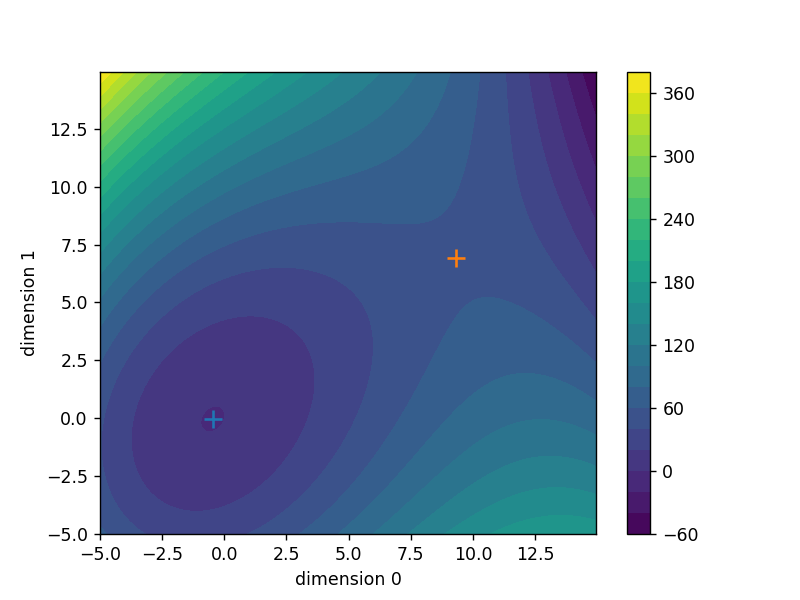

In [18]:
fig, ax = plt.subplots()
cont = ax.contourf(x_list, x_list, y_list, 25)
plt.scatter(*xmin_0, s=100, marker="+")
plt.scatter(*xmin_1, s=100, marker="+")
ax.set_xlabel("dimension 0")
ax.set_ylabel("dimension 1")
ax = fig.colorbar(cont)

### 二阶自动求导：程序

事实上，上述函数 $y$ 并没有下界，这也能从上图中右上角的趋势中看出；因此简单的梯度下降法在初猜偏离极值点附近时，很可能会在学习率 `lr` 设置得较大时出现这种不收敛的情况：

In [19]:
x = torch.tensor([-10., 10.], requires_grad=True)
print("Initial x:", x)

lr = 0.5
for epoch in range(7):
    y = A @ x + B @ x @ x + C @ x @ x @ x
    print(float(y))
    g = grad(y, x)[0]
    x = x - g * lr
    x = x.detach().clone().requires_grad_()

Initial x: tensor([-10.,  10.], requires_grad=True)
465.36041259765625
-69.391845703125
-13590.681640625
-7374935.0
-1465419038720.0
-5.513727300032158e+22
nan


事实上以上述初猜，即使调变学习率也很难出现任何收敛的趋势。但对于下述使用了 Newton 二阶收敛的做法，一般来说只要学习率 `lr` 不超过 1，可以迅速收到极值点 (但也可能收到鞍点)：

In [20]:
x = torch.tensor([-1., 1.], requires_grad=True) * 10
print("Initial x:", x)

lr = 1
for epoch in range(7):
    y = A @ x + B @ x @ x + C @ x @ x @ x
    print(float(y))
    g = grad(y, x, create_graph=True)[0]
    H = torch.stack([grad(g, x, grad_outputs=arr, create_graph=True)[0] for arr in torch.eye(d)]).detach()
    g = g.detach()
    x = x - torch.inverse(H) @ g * lr
    x = x.detach().clone().requires_grad_()
print("Optimized x:", x)

Initial x: tensor([-10.,  10.], grad_fn=<MulBackward0>)
465.36041259765625
23.22213363647461
0.332691490650177
-0.36113929748535156
-0.3630421757698059
-0.3630422055721283
-0.3630422055721283
Optimized x: tensor([-0.47197, -0.03560], requires_grad=True)


### $y$ 的一阶导数

我们现在对一个任意确定的 `x` $x_i$ 来分析函数 `y` $y$ 求导的问题。

$$
y = \sum_i A_i x_i + \sum_{ij} B_{ij} x_i x_j + \sum_{ijk} C_{ijk} x_i x_j x_k
$$

In [21]:
torch.random.manual_seed(0)
x = torch.randn(d, requires_grad=True)
y = A @ x + B @ x @ x + C @ x @ x @ x

任何优化问题需要求取一阶导数。一阶导数的求取我们应该已经比较熟悉了：

$$
\frac{\partial y}{\partial x_i} = A_i + \sum_j (B_{ij} + B_{ji}) x_j + \sum_{jk} (C_{ijk} + C_{jik} + C_{kji}) x_j x_k
$$

上述推导过程中需要利用到 $i, j, k$ 角标等价的技巧。

In [22]:
A + (B + B.T) @ x + (C + C.transpose(0, 1) + C.transpose(0, 2)) @ x @ x 

tensor([ 6.09431, -2.24798], grad_fn=<AddBackward0>)

PyTorch 的自动求导程序可以通过如下方式求取一阶导数 `g`：

In [23]:
g = grad(y, x, create_graph=True)[0]
g

tensor([ 6.09431, -2.24798], grad_fn=<AddBackward0>)

### $y$ 的二阶导数

二阶导数通常也称为 Hessian 矩阵。

$$
\frac{\partial^2 y}{\partial x_i \partial x_j} = (B_{ij} + B_{ji}) + \sum_{k} (C_{ijk} + C_{ikj} + C_{jik} + C_{jki} + C_{kji} + C_{kij}) x_k
$$

上式仍然利用了 $j, k$ 角标等价的技巧。我们用 `Cp2` 表示六个 $\mathbf{C}$ 的转置张量之和：

In [24]:
Cp2 = (
    C.permute(0, 1, 2) + C.permute(0, 2, 1)
  + C.permute(1, 0, 2) + C.permute(1, 2, 0)
  + C.permute(2, 0, 1) + C.permute(2, 1, 0)
)

那么 Hessian 矩阵可以写为

In [25]:
B + B.T + Cp2 @ x

tensor([[ 2.39952, -0.79906],
        [-0.79906,  2.35762]], grad_fn=<AddBackward0>)

我们 [曾经](./Autograd_TensorContract.ipynb#矩阵-向量乘积的自动求导) 指出过，在 PyTorch 中，真正的二阶梯度 `H` 是可以获得的，但需要依赖矩阵 $\delta_{ii_0}$ `torch.eye(d)`。获得二阶梯度的前提是一阶梯度 `g` 已经被求出，并且一阶梯度的导数图 (`create_graph=True` 选项) 已经被绘制。

In [26]:
H = torch.stack([grad(g, x, grad_outputs=arr, retain_graph=True)[0] for arr in torch.eye(d)])
H

tensor([[ 2.39952, -0.79906],
        [-0.79906,  2.35762]])